In [1]:
# Import required libraries
import pandas as pd

from sklearn.model_selection import train_test_split

import pylangkit.naive_bayes as nb

In [2]:
# Read input data
df = pd.read_csv('resources/lang_data.csv')

In [3]:
# Show data' statistics
# Statistics shown that there exists some empty data in text column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2839 entries, 0 to 2838
Data columns (total 2 columns):
text        2761 non-null object
language    2839 non-null object
dtypes: object(2)
memory usage: 44.4+ KB


In [4]:
# Display empty samples (78 entries)
df[df.text.isnull()]

,text,language
7,NaN,Afrikaans
11,NaN,Afrikaans
17,NaN,Afrikaans
51,NaN,Nederlands
70,NaN,English
96,NaN,English
107,NaN,Afrikaans
116,NaN,English
120,NaN,Afrikaans
187,NaN,Afrikaans


In [5]:
# Remove emtpy samples
df.dropna(inplace=True)

In [6]:
# So far we have a dataset, preperred for further processing, 
# e.g. training language classifying model
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2761 entries, 0 to 2838
Data columns (total 2 columns):
text        2761 non-null object
language    2761 non-null object
dtypes: object(2)
memory usage: 64.7+ KB


In [7]:
# Show language categories and text distributions over languages
df.language.value_counts()

English       2055
Afrikaans      639
Nederlands      67
Name: language, dtype: int64

In [8]:
# Show first 5 rows of dataset for Nederlands language
df[df.language == 'Nederlands'].head()

,text,language
64,"Je moet geen oude schoenen weggooien, voordat ...",Nederlands
93,"Wie zaait, zal oogsten.",Nederlands
119,"Wie het eerst komt, het eerst maalt.",Nederlands
143,Gedane zaken nemen geen keer.,Nederlands
170,Aan alles komt een eind.,Nederlands


In [ ]:
# Split of dataset to train and test (80% train, 20% test)
# And save it to the files
df_train, df_test = train_test_split(df, test_size = 0.2)

df_train.to_csv('resources/lang_data_train.csv', index=False)
df_test.to_csv('resources/lang_data_test.csv', index=False)

In [9]:
# Or, load preperred datasets from file.
df_train = pd.read_csv('resources/lang_data_train.csv')
df_test = pd.read_csv('resources/lang_data_test.csv')

In [10]:
# See if we distribute all languages properly over train and test sets
# e.g. for Nederlands language we have text data in both train and test sets
print('Train\n{}\n\nTest\n{}'.format(df_train.language.value_counts(), df_test.language.value_counts()))

Train
English       1656
Afrikaans      498
Nederlands      54
Name: language, dtype: int64

Test
English       399
Afrikaans     141
Nederlands     13
Name: language, dtype: int64


In [11]:
# Create a model
model = nb.NaiveBayes()

In [12]:
# Train model
# and save trained model on disk
# model.fit(df_train.as_matrix())
# model.dump_model('trained_model.pickle')

# Or load trainded model from file
model.load_model('resources/trained_model.pickle')

In [13]:
# Make prediction and print out misclassified text samples
predicted = model.classify(df_test.text.as_matrix())

df = pd.DataFrame(list(map(lambda x: (x[0][0], x[0][1], x[1],), zip(predicted, df_test.language))), 
                 columns=['text', 'predicted', 'actual'])
df.loc[df.predicted != df.actual]

,text,predicted,actual
30,Schijn bedriegt.,Afrikaans,Nederlands
45,Het is niet al goud wat blinkt.,Afrikaans,Nederlands
186,Misdaad loont niet.,Afrikaans,Nederlands
259,Soort zoekt soort.,Afrikaans,Nederlands
311,Oude liefde roest niet.,Afrikaans,Nederlands
371,"Wie het eerst komt, het eerst maalt.",Afrikaans,Nederlands
407,Geen woorden maar daden.,Afrikaans,Nederlands
517,Een gewaarschuwd mens telt voor twee.,Afrikaans,Nederlands


Evaluation
==========

In [14]:
# Confusion matrix
from sklearn.metrics import confusion_matrix


y_true = df_test.language
y_predicted = list(map(lambda x: x[1], predicted))
confusion_matrix(y_true, y_predicted, labels=['English', 'Afrikaans', 'Nederlands'])

array([[399,   0,   0],
       [  0, 141,   0],
       [  0,   8,   5]])

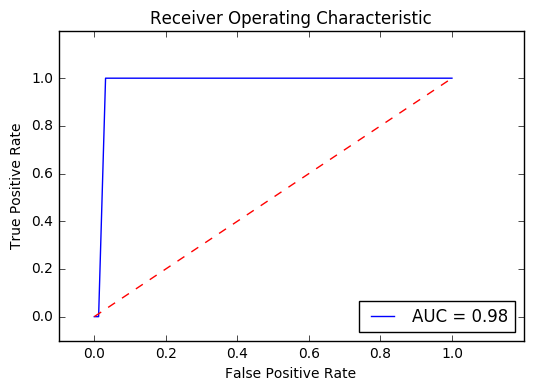

In [16]:
# Precision, Recall, ROC
import numpy as np
from sklearn.metrics import roc_curve, auc


mapped_values = dict(English=0, Afrikaans=1, Nederlands=2)
y_true = np.array(df_test.language.map(mapped_values).values, dtype=float)
y_predicted = np.array([mapped_values[x[1]] for x in predicted], dtype=float)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_predicted, pos_label=True)
roc_auc = auc(false_positive_rate, true_positive_rate)


import matplotlib.pyplot as plt
%matplotlib inline

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [17]:
# Classification report
from sklearn.metrics import classification_report

print(classification_report(y_true, y_predicted))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       399
        1.0       0.95      1.00      0.97       141
        2.0       1.00      0.38      0.56        13

avg / total       0.99      0.99      0.98       553

